# Local Variational Inference for a Logit Model

The local variational method is well explained by Bishop (2006). This demo applies this method in the context of state-estimation in a linear state-space model that combines a Gaussian state-evolution model with a logit observation model. Here, the logistic function links a continuous state with discrete observations. The model is chosen as:

\begin{align*}
    x_t &\sim \mathcal{N}(x_{t-1} + 0.1, 0.01)\\
    y_t &\sim \mathcal{B}er(\sigma(x_t))\,.
\end{align*}

We start by generating a dataset.

In [1]:
using Random

# Generate data set
Random.seed!(123)
n_samples = 40
σ(x) = 1/(1 + exp(-x))

x_data = []
y_data = []
x_prev = -2.0
for t=1:n_samples
    push!(x_data, x_prev + 0.1 + sqrt(0.01)*randn()) # State transition
    push!(y_data, σ(x_data[end]) > rand()); # Observation
    x_prev = x_data[end]
end

# Model specification

The model specification treats the local variational parameters `xi` as variables that we wish to optimize.

In [2]:
using ForneyLab

g = FactorGraph()

# State prior
@RV x_0 ~ GaussianMeanVariance(0.0, 100.0)

x = Vector{Variable}(undef, n_samples)
xi = Vector{Variable}(undef, n_samples)
y = Vector{Variable}(undef, n_samples)
x_t_min = x_0
for t = 1:n_samples
    @RV x[t] ~ GaussianMeanPrecision(x_t_min + 0.1, 100.0)
    @RV xi[t] ~ placeholder(:xi, index=t)
    @RV y[t] ~ Logit(x[t], xi[t])

    # Data placeholder
    placeholder(y[t], :y, index=t)
    
    # Reset state for next step
    x_t_min = x[t]
end
;

# Algorithm generation

Since we are interested in optimizing the local variational parameters `xi` together with the hidden state sequence `x`, we signal to ForneyLab that we wish to estimate `xi` as well.

In [3]:
q = RecognitionFactorization([x_0; x], xi, ids=[:X, :Xi])
algo = variationalAlgorithm(q);

In [22]:
println(algo[8:436])

# You have created an algorithm that requires updates for (a) clamped parameter(s).
# This algorithm requires the definition of a custom `optimize!` function that updates the parameter value(s)
# by altering the `data` dictionary in-place. The custom `optimize!` function may be based on the mockup below:

# function optimizeXi!(data::Dict, marginals::Dict=Dict(), messages::Vector{Message}=initXi())
# 	...
# 	return data
# end


ForneyLab provides mockup code for the local optimization, which we must manually define. For convenience, we will combine the computation of the `xi` messages with an analytic optimization step. The mode of the log-message will become the new estimate for the corresponding `xi[t]`.

In [5]:
function optimizeXi!(data::Dict, marginals::Dict)
    for t=1:n_samples
        msg_t = ruleVBLogitXi(ProbabilityDistribution(Univariate, PointMass, m=data[:y][t]), 
                              marginals[:x_*t], 
                              nothing)
        data[:xi][t] = msg_t.dist.params[:mode]
    end
    
    return data
end
;

With local variational methods the free energy remains an upper-bound on the surprisal. We generate an algorithm for evaluating the free energy.

In [6]:
algo_F = freeEnergyAlgorithm(q);

In [7]:
# println(algo_F) # Uncomment to inspect free energy algorithm code

# Execution

For execution we initialize the local variational parameters and iterate the automatically derived `stepX!()` and manually defined `optimizeXi()` functions until convergence of the free energy.

In [8]:
eval(Meta.parse(algo))
eval(Meta.parse(algo_F));

In [9]:
xi_init = ones(n_samples)
marginals = Dict()
data = Dict(:y  => y_data,
            :xi => xi_init)

n_its = 10
F = Vector{Float64}(undef, n_its)
for i = 1:n_its
    stepX!(data, marginals) # Update marginals of hidden state
    optimizeXi!(data, marginals) # Update data with new estimates for xi
    
    F[i] = freeEnergy(data, marginals) # Evaluate free energy
end

# Results

Results show that the algorithm accurately estimates the hidden state and that the free energy converges nicely.

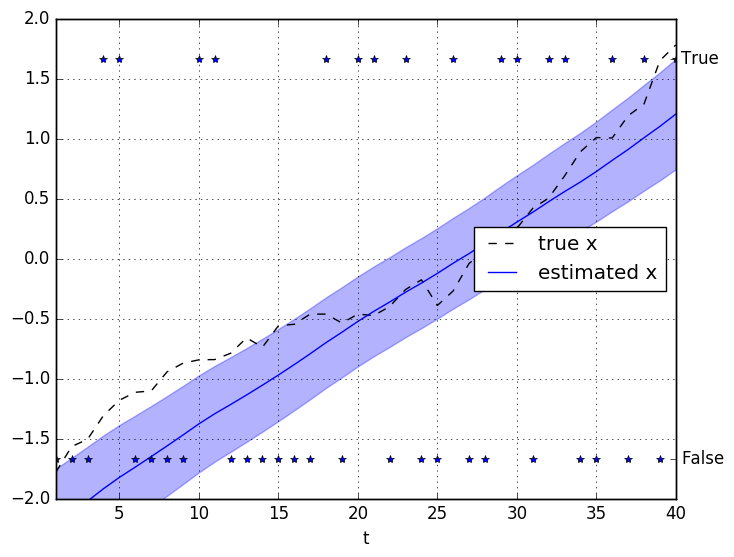

In [10]:
using PyPlot

# Extract posterior statistics
m_x = [mean(marginals[:x_*t]) for t = 1:n_samples]
v_x = [var(marginals[:x_*t]) for t = 1:n_samples]

plot(collect(1:n_samples), x_data, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(collect(1:n_samples), m_x-sqrt.(v_x), m_x+sqrt.(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
ylim(-2, 2)
legend(loc=7)

ax = gca()
ax.twinx()
plot(collect(1:n_samples), y_data, "b*", label="y")
yticks([0.0, 1.0], ["False", "True"]);
ylim(-0.1, 1.1)
xlim(1, n_samples);

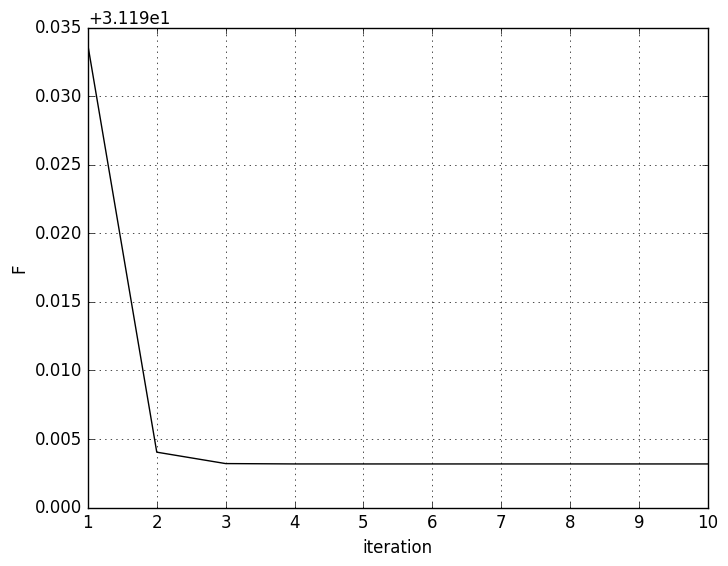

In [11]:
plot(1:n_its, F, color="black")
grid("on")
xlabel("iteration")
ylabel("F");